In [1]:
#Note - Total Runtime for Code - 1 hour
# === 1. Problem Definition ===
# Goal: Binary classification of income levels using machine learning models.
# We aim to compare models and evaluate fairness.


import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
# Load LIBSVM-format dataset
def load_libsvm(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            label = int(parts[0])
            features = {int(k.split(":")[0]): float(k.split(":")[1]) for k in parts[1:]}
            features["label"] = label
            data.append(features)
    return pd.DataFrame(data).fillna(0)

# File paths
train_file = "/content/a8a - training.txt"
test_file = "/content/a8a - testing.txt"

# Load datasets
df_train = load_libsvm(train_file)
df_test = load_libsvm(test_file)

# Convert labels: -1 -> 0, +1 -> 1
df_train['label'] = df_train['label'].map({-1: 0, 1: 1})
df_test['label'] = df_test['label'].map({-1: 0, 1: 1})

# Ensure feature alignment
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0

df_test = df_test[df_train.columns]

# Separate features and labels
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']


In [3]:
# === 3. Data Preprocessing ===
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training Set Class Distribution:
label
0    17190
1     5506
Name: count, dtype: int64

Testing Set Class Distribution:
label
0    7530
1    2335
Name: count, dtype: int64


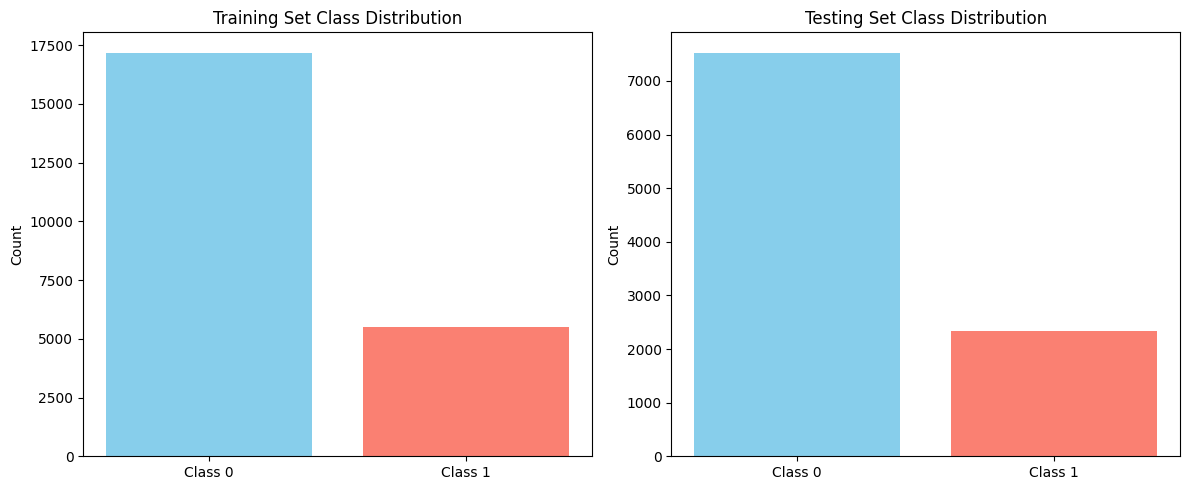

In [4]:
# checking for imbalance
def plot_class_distribution(y_train, y_test):
    train_counts = y_train.value_counts()
    test_counts = y_test.value_counts()

    print("Training Set Class Distribution:")
    print(train_counts)
    print("\nTesting Set Class Distribution:")
    print(test_counts)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].bar(train_counts.index, train_counts.values, color=['skyblue', 'salmon'])
    ax[0].set_title('Training Set Class Distribution')
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels(['Class 0', 'Class 1'])
    ax[0].set_ylabel('Count')

    ax[1].bar(test_counts.index, test_counts.values, color=['skyblue', 'salmon'])
    ax[1].set_title('Testing Set Class Distribution')
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels(['Class 0', 'Class 1'])
    ax[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Call the function
plot_class_distribution(y_train, y_test)

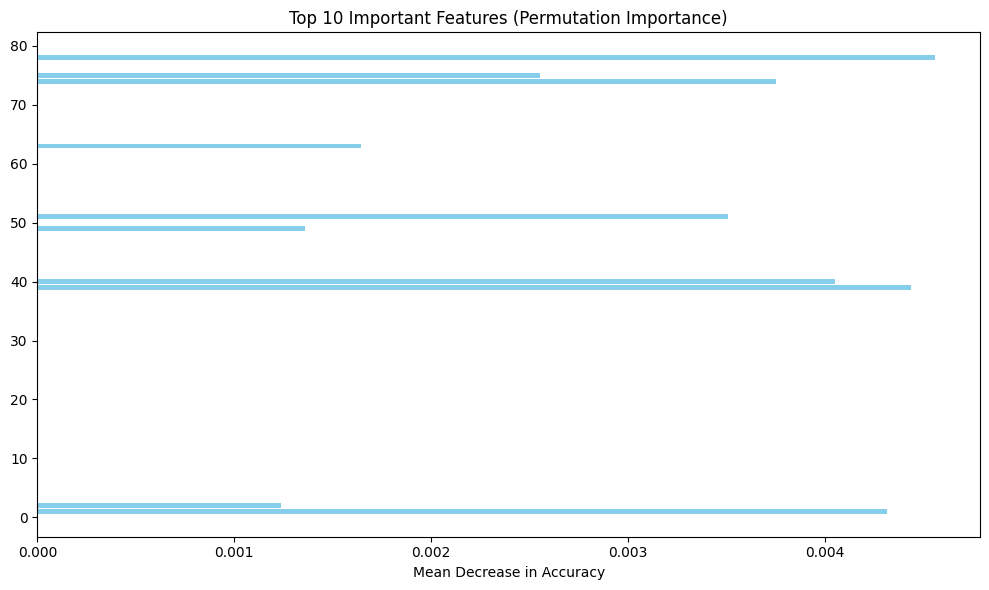

In [5]:
# === 4. Feature Engineering (Feature Importance) ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

importance = permutation_importance(rf, X_test_scaled, y_test, scoring="accuracy")
importance_mean = importance.importances_mean

# Sort features by their importance
sorted_idx = np.argsort(importance_mean)[::-1]

# Select top 10 important features to reduce clutter
top_n = 10
top_idx = sorted_idx[:top_n]
top_features = X_train.columns[top_idx]
top_importance = importance_mean[top_idx]

# Plotting the feature importance for the top N features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color='skyblue')
plt.title(f"Top {top_n} Important Features (Permutation Importance)")
plt.xlabel("Mean Decrease in Accuracy")
plt.tight_layout()
plt.show()


In [6]:
# === 5. Model Selection & Training ===
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naïve Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42),
    "Gaussian Process": GaussianProcessClassifier(kernel=RBF())
}

subset_size = 5000  # Adjust based on available RAM
# Use scaled data for GPC subset
X_train_gpc = X_train_scaled[:subset_size]  # Changed to use scaled data
y_train_gpc = y_train[:subset_size]

# Hyperparameter tuning (Grid Search) on reduced dataset
X_train_subset = X_train_scaled[:subset_size] # Use scaled data for hyperparameter tuning
y_train_subset = y_train[:subset_size]

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_rf.fit(X_train_subset, y_train_subset)

param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.1],
    "kernel": ["rbf", "linear"]
}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_svm.fit(X_train_subset, y_train_subset)

# Modify training function to handle GPC separately and include hyperparameter tuning
def train_and_evaluate(X_train, y_train, X_test, y_test, models, dataset_name="Default"):
    print(f"\n=== Training Models on {dataset_name} ===")  # Added dataset_name to print proper heading
    for name, model in models.items():
        # Apply hyperparameter tuning for RF & SVM
        if name == "Random Forest":
            model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
        elif name == "Support Vector Machine":
            model = SVC(**grid_search_svm.best_params_, probability=True)

        # Use reduced dataset and original features for GPC
        if name == "Gaussian Process":
            model.fit(X_train_gpc, y_train_gpc)
            y_pred = model.predict(X_test_scaled) # Use scaled data for prediction
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        print(f"\n{name} Performance:")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))
        if y_prob is not None:
            print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Training models without balancing techniques
train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, models, dataset_name="No Balancing")



=== Training Models on No Balancing ===

Logistic Regression Performance:
Accuracy: 0.8538266599087684
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      7530
           1       0.72      0.62      0.67      2335

    accuracy                           0.85      9865
   macro avg       0.80      0.77      0.79      9865
weighted avg       0.85      0.85      0.85      9865

ROC-AUC Score: 0.9073226295389463

Support Vector Machine Performance:
Accuracy: 0.8515965534718702
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      7530
           1       0.72      0.60      0.66      2335

    accuracy                           0.85      9865
   macro avg       0.80      0.77      0.78      9865
weighted avg       0.85      0.85      0.85      9865

ROC-AUC Score: 0.9052242990919974

Random Forest Performance:
Accuracy: 0.8477445514445008
Cla

In [7]:
# === 6. Model Optimization (Handling Class Imbalance) ===
# Apply balancing techniques
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Normalize balanced datasets
X_train_smote = scaler.fit_transform(X_train_smote)
X_train_under = scaler.fit_transform(X_train_under)
X_train_smoteenn = scaler.fit_transform(X_train_smoteenn)

# Train and evaluate on balanced datasets
train_and_evaluate(X_train_smote, y_train_smote, X_test_scaled, y_test, models, dataset_name="SMOTE")
train_and_evaluate(X_train_under, y_train_under, X_test_scaled, y_test, models, dataset_name="Random Undersampling")
train_and_evaluate(X_train_smoteenn, y_train_smoteenn, X_test_scaled, y_test, models, dataset_name="SMOTE + ENN")  # NOTE: Runtime = 20 minutes


=== Training Models on SMOTE ===

Logistic Regression Performance:
Accuracy: 0.807704004054739
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.79      0.86      7530
           1       0.56      0.85      0.68      2335

    accuracy                           0.81      9865
   macro avg       0.75      0.82      0.77      9865
weighted avg       0.85      0.81      0.82      9865

ROC-AUC Score: 0.9060656446306139

Support Vector Machine Performance:
Accuracy: 0.7998986315255956
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86      7530
           1       0.55      0.86      0.67      2335

    accuracy                           0.80      9865
   macro avg       0.75      0.82      0.76      9865
weighted avg       0.85      0.80      0.81      9865

ROC-AUC Score: 0.9042115335943876

Random Forest Performance:
Accuracy: 0.8400405473897617
Classificat

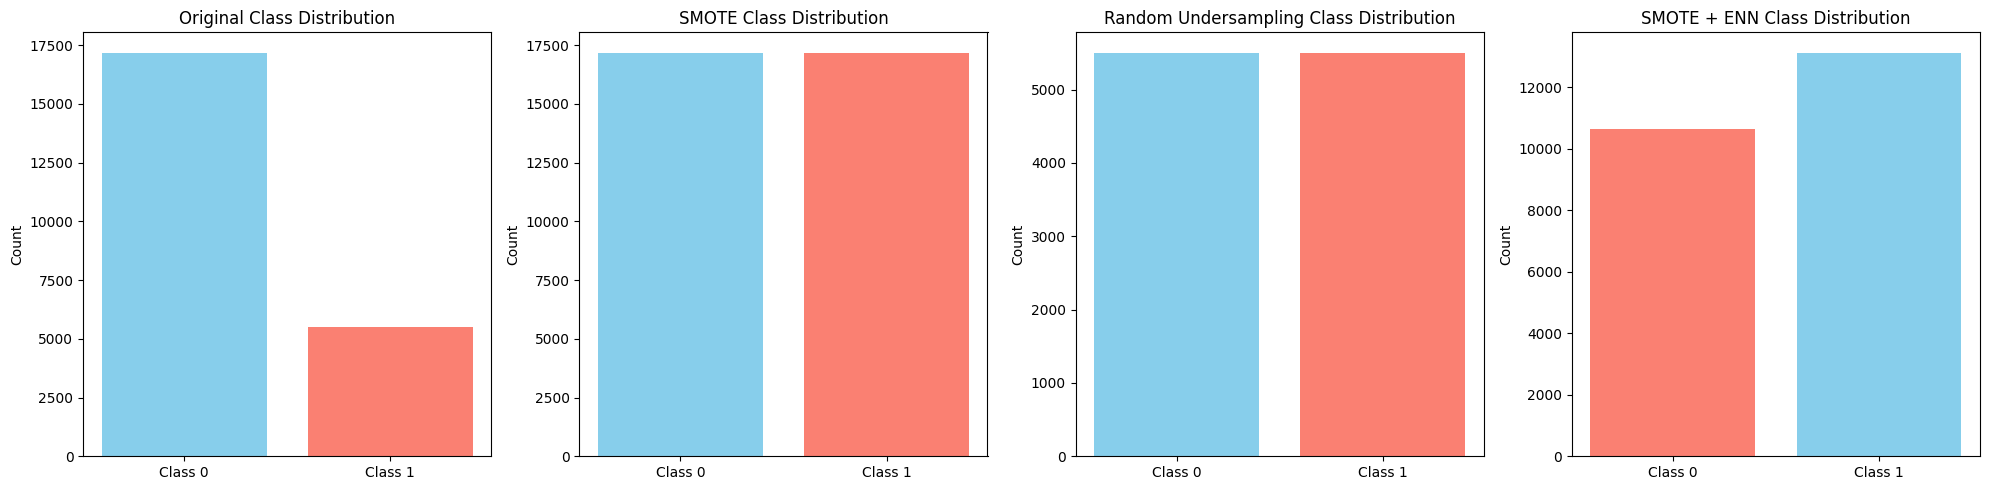

In [8]:
# Visualize class distribution after balancing
def plot_balanced_class_distribution(y_original, y_smote, y_under, y_smoteenn):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for i, (title, data) in enumerate([
        ('Original', y_original),
        ('SMOTE', y_smote),
        ('Random Undersampling', y_under),
        ('SMOTE + ENN', y_smoteenn)
    ]):
        axs[i].bar(data.value_counts().index, data.value_counts().values, color=['skyblue', 'salmon'])
        axs[i].set_title(f'{title} Class Distribution')
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['Class 0', 'Class 1'])
        axs[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Call the function to visualize class distributions
plot_balanced_class_distribution(y_train, y_train_smote, y_train_under, y_train_smoteenn)


In [9]:
# === 7. Fairness Analysis ===
def analyze_fairness(y_true, y_pred, sensitive_feature):
    df_fairness = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': sensitive_feature})
    fairness_results = df_fairness.groupby('group')['y_pred'].mean()
    print("Positive Prediction Rate per Group:")
    print(fairness_results)
    for group in df_fairness['group'].unique():
        group_data = df_fairness[df_fairness['group'] == group]
        tn, fp, fn, tp = confusion_matrix(group_data['y_true'], group_data['y_pred']).ravel()
        print(f"\nFairness Metrics for Group {group}:")
        print(f"False Positive Rate: {fp / (fp + tn) if (fp + tn) > 0 else 0}")
        print(f"False Negative Rate: {fn / (fn + tp) if (fn + tp) > 0 else 0}")

# Assuming first column is a proxy for fairness check
y_pred = rf.predict(X_test_scaled)
sensitive_feature = X_test.iloc[:, 0]
analyze_fairness(y_test, y_pred, sensitive_feature)

Positive Prediction Rate per Group:
group
0.0    0.203183
1.0    0.269527
Name: y_pred, dtype: float64

Fairness Metrics for Group 0.0:
False Positive Rate: 0.09041591320072333
False Negative Rate: 0.3951990632318501

Fairness Metrics for Group 1.0:
False Positive Rate: 0.11817553559087768
False Negative Rate: 0.38118022328548645
